# Generating Architectures

# Calculating Results

In [1]:
import os
THIS_SCRIPT_DIR = os.getcwd()

def runMapper(file, layer, outputDirectory, architectureDirectory, componentsDirectory, layerDirectory, mapperPath):
    filename = file[:-5]
    layername = layer[:-5]
    if not os.path.isdir(os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layername)):
        spec = tl.Specification.from_yaml_files(
                os.path.join(architectureDirectory, file),
                os.path.join("components/*.yaml"),
                os.path.join(THIS_SCRIPT_DIR, layerDirectory + layer),
                os.path.join(THIS_SCRIPT_DIR, "mapper.yaml"),
            )
        tl.call_mapper(spec, output_dir=os.path.join(THIS_SCRIPT_DIR, outputDirectory + filename + "/" + layername))

In [2]:
def parseStatsFile(file):
    with open(file) as f:
        lines = [line.rstrip() for line in f]
    idx = lines.index("Summary Stats")
    
    utilizationStr = lines[idx+3]
    utilizationStr = utilizationStr[13:]
    utilizationStr = utilizationStr.strip('%')
    utilization = float(utilizationStr)/100

    cyclesStr = lines[idx+4]
    cyclesStr = cyclesStr[8:]
    cycles = int(cyclesStr)

    energyStr = lines[idx+5]
    energyStr = energyStr[8:]
    energyStr = energyStr[:-3]
    energy = float(energyStr)

    
    edpStr = lines[idx+6]
    edpStr = edpStr[14:]
    (edpValueStr, edpExponentStr) = edpStr.split("e")
    edpExponent = int(edpExponentStr)
    edpValue = float(edpValueStr)
    edp = edpValue * (10**edpExponent)
    
    
    return {"utilization": utilization, "cycles": cycles, "energy": energy, "edp": edp}

In [3]:
import os
THIS_SCRIPT_DIR = os.getcwd()


def calculateCosts(cyclesPerSecond, folder, optimizationMetric):
    architectureFolders = os.listdir(folder)
    if ".ipynb_checkpoints" in architectureFolders:
        architectureFolders.remove(".ipynb_checkpoints")
    architectureFolders.sort()
    costs = []
    for architectureFolder in architectureFolders:
        #print(architectureFolder)
        layerFolders = os.listdir(folder + "/" + architectureFolder)
        if ".ipynb_checkpoints" in layerFolders:
            layerFolders.remove(".ipynb_checkpoints")
        layerFolders.sort()
        layerCosts = []
        for layerFolder in layerFolders:
            stats = parseStatsFile(os.path.join(folder, architectureFolder, layerFolder, "timeloop-mapper.stats.txt"))
            cost = 0
            if optimizationMetric == "delay":
                cost = stats["cycles"]/cyclesPerSecond #convert from cycles to seconds
            elif optimizationMetric == "energy":
                cost = stats["energy"]
            elif optimizationMetric == "edp":
                cost = stats["edp"]/cyclesPerSecond #convert from Joule*cycle to Joule*second
            else:
                print(optimizationMetric)
            #print(cost)
            layerCosts.append(cost)
        costs.append(layerCosts)
    return costs

In [7]:
import pygad

def findBestPath(batchSize, costs, reconfigCost):

    print(costs)
    
    gene_space = []
    for i in range(len(costs[0])):
        gene_space.append(range(len(costs)))

    def fitness_func(ga_instance, solution, solution_idx):
        totalCost = costs[solution[0]][0]
        for i in range (1, len(gene_space)):
            totalCost = totalCost + costs[solution[i]][i]
            if not solution[i] == solution[i-1]:
                totalCost = totalCost + reconfigCost/batchSize
        return 1.0/totalCost

    ga_instance = pygad.GA(num_generations=10000,
                       num_parents_mating=4,
                       fitness_func=fitness_func,
                       sol_per_pop=20,
                       num_genes=len(gene_space),
                       mutation_percent_genes=10,
                       gene_space=gene_space,
                       gene_type=int)


    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

    totalCost = costs[solution[0]][0]
    for i in range (1, len(gene_space)):
        totalCost = totalCost + costs[solution[i]][i]
        if not solution[i] == solution[i-1]:
            totalCost = totalCost + reconfigCost/batchSize    

    ga_instance.plot_fitness()

    return totalCost

  0%|          | 0/646 [00:00<?, ?it/s]

Timeloop done
[[2754.77, 783150.01, 69945.0, 121885.13, 44297.23, 51347.02, 114588.01, 13527.94, 94965.27, 23749.12, 305838.59, 22873.46, 63754.18, 81060.74, 258427.99, 7014.71, 133050.01, 7351.84, 686.94], [2885.02, 33818.69, 12812.29, 28449.79, 11981.86, 29535.58, 12546.0, 24562.77, 9842.15, 20877.12, 42273.69, 15535.28, 32609.44, 15370.07, 30456.71, 13924.21, 29400.91, 15590.13, 1284.11], [2961.11, 27026.45, 10540.65, 17219.26, 8427.75, 19510.55, 9946.03, 23682.04, 4909.28, 8799.22, 24657.62, 16889.9, 18017.24, 8287.35, 15712.67, 9255.45, 15323.9, 8734.33, 1299.27], [2943.11, 46328.79, 17452.25, 36490.62, 15900.05, 35293.02, 9913.11, 25077.69, 8755.59, 13031.1, 29874.53, 18203.5, 31517.3, 16827.24, 33508.55, 13459.01, 28779.6, 18007.66, 1308.63]]
costs calculated
[[2754.77, 783150.01, 69945.0, 121885.13, 44297.23, 51347.02, 114588.01, 13527.94, 94965.27, 23749.12, 305838.59, 22873.46, 63754.18, 81060.74, 258427.99, 7014.71, 133050.01, 7351.84, 686.94], [2885.02, 33818.69, 12812.29, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 0 2 0 0]
Fitness value of the best solution = 4.2079875261784165e-06


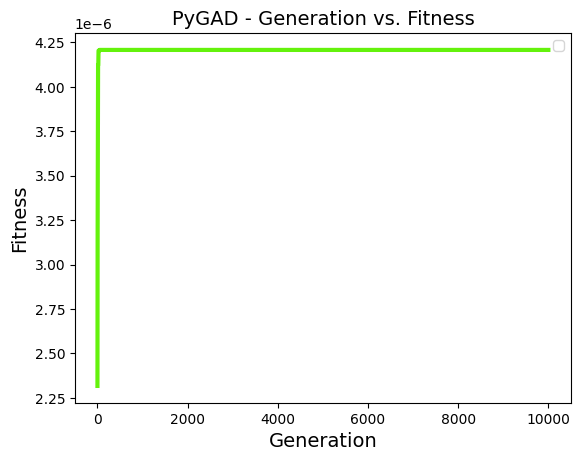

Total (amortized) cost of the best solution: 237643.29
eyeriss_like : 0 2200267.9599999995
simpleCS32x32 : 1 383755.82
simpleOS32x32 : 2 251200.06999999998
simpleRS32x32 : 3 402671.35


  0%|          | 0/442 [00:00<?, ?it/s]

Timeloop done
[[285.02, 6803.91, 5267.7, 10623.88, 9337.81, 18717.0, 18717.0, 9281.53, 10272.72, 10272.72, 4712.45, 4712.45, 4712.45], [551.82, 4570.48, 1995.81, 4422.41, 2741.45, 5770.84, 5770.84, 2118.04, 4426.58, 4426.58, 1448.74, 1448.74, 1448.74], [511.65, 2866.32, 1754.71, 3019.22, 1430.77, 3462.86, 3462.86, 1176.79, 3280.9, 3280.9, 794.24, 794.24, 794.24], [514.74, 4736.18, 3016.45, 5824.75, 2761.22, 4041.39, 4041.39, 2011.35, 4144.06, 4144.06, 861.23, 861.23, 861.23]]
costs calculated
[[285.02, 6803.91, 5267.7, 10623.88, 9337.81, 18717.0, 18717.0, 9281.53, 10272.72, 10272.72, 4712.45, 4712.45, 4712.45], [551.82, 4570.48, 1995.81, 4422.41, 2741.45, 5770.84, 5770.84, 2118.04, 4426.58, 4426.58, 1448.74, 1448.74, 1448.74], [511.65, 2866.32, 1754.71, 3019.22, 1430.77, 3462.86, 3462.86, 1176.79, 3280.9, 3280.9, 794.24, 794.24, 794.24], [514.74, 4736.18, 3016.45, 5824.75, 2761.22, 4041.39, 4041.39, 2011.35, 4144.06, 4144.06, 861.23, 861.23, 861.23]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [2 2 2 2 2 2 2 2 2 2 2 2 2]
Fitness value of the best solution = 3.755205653837631e-05


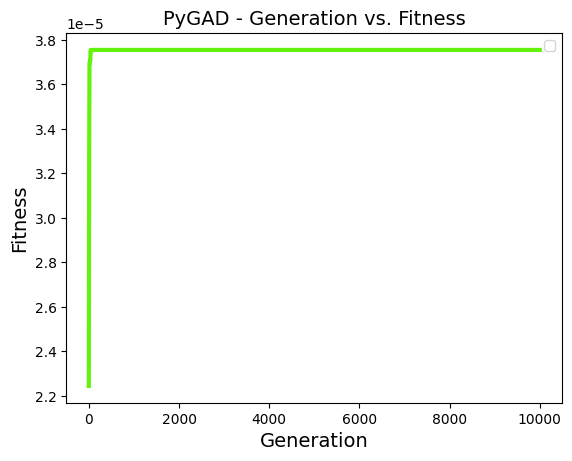

Total (amortized) cost of the best solution: 26629.700000000008
eyeriss_like : 0 113716.64
simpleCS32x32 : 1 41141.06999999999
simpleOS32x32 : 2 26629.700000000008
simpleRS32x32 : 3 37819.280000000006


  0%|          | 0/680 [00:00<?, ?it/s]

Timeloop done
[[632.7, 1306.28, 1306.28, 1306.28, 1306.28, 588.25, 1168.82, 44.59, 1168.82, 1168.82, 136.79, 3818.89, 46.52, 3818.89, 3818.89, 583.59, 1161.63, 67.57, 1161.63, 1161.63], [223.14, 302.22, 302.22, 302.22, 302.22, 114.8, 234.88, 46.79, 234.88, 234.88, 121.01, 244.59, 44.31, 244.59, 244.59, 229.12, 455.22, 53.61, 455.22, 455.22], [245.97, 193.91, 193.91, 193.91, 193.91, 80.28, 148.4, 25.58, 148.4, 148.4, 98.42, 191.86, 19.08, 191.86, 191.86, 206.62, 412.53, 27.14, 412.53, 412.53], [259.75, 373.56, 373.56, 373.56, 373.56, 114.79, 260.03, 36.34, 260.03, 260.03, 112.19, 218.33, 20.33, 218.33, 218.33, 222.23, 441.43, 28.28, 441.43, 441.43]]
costs calculated
[[632.7, 1306.28, 1306.28, 1306.28, 1306.28, 588.25, 1168.82, 44.59, 1168.82, 1168.82, 136.79, 3818.89, 46.52, 3818.89, 3818.89, 583.59, 1161.63, 67.57, 1161.63, 1161.63], [223.14, 302.22, 302.22, 302.22, 302.22, 114.8, 234.88, 46.79, 234.88, 234.88, 121.01, 244.59, 44.31, 244.59, 244.59, 229.12, 455.22, 53.61, 455.22, 455.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Fitness value of the best solution = 0.0002675871665194937


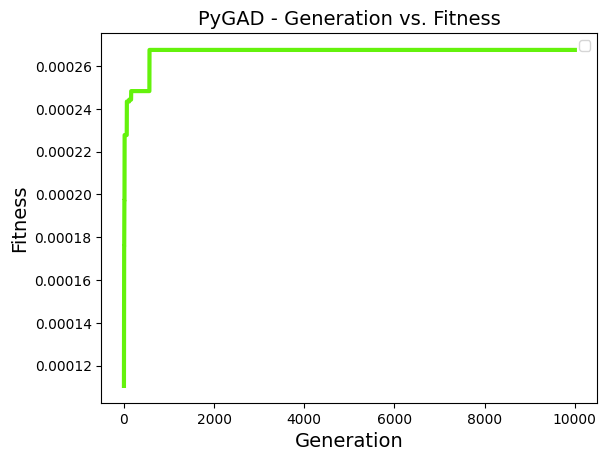

Total (amortized) cost of the best solution: 3737.1000000000004
eyeriss_like : 0 25773.15
simpleCS32x32 : 1 4845.730000000001
simpleOS32x32 : 2 3737.1000000000004
simpleRS32x32 : 3 5047.5199999999995


In [52]:
import os
import timeloopfe.v4 as tl
from joblib import Parallel, delayed
from tqdm.auto import tqdm


THIS_SCRIPT_DIR = os.getcwd()
#THIS_SCRIPT_DIR = "/localdata/boerob00/Masterarbeit/workspace"
architecturePath = os.path.join(THIS_SCRIPT_DIR, "customArchitecturesFinal/")

uNetPath = os.path.join(THIS_SCRIPT_DIR, "example_designs/layer_shapes/UNet/")
vgg16Path = os.path.join(THIS_SCRIPT_DIR, "example_designs/layer_shapes/vgg16/")
resNet18Path = os.path.join(THIS_SCRIPT_DIR, "example_designs/layer_shapes/resnet18/")

uNetOutputPath = os.path.join(THIS_SCRIPT_DIR, "outputsFinal.UNet/")
vgg16OutputPath = os.path.join(THIS_SCRIPT_DIR, "outputsFinal.vgg16/")
resNet18OutputPath = os.path.join(THIS_SCRIPT_DIR, "outputsFinal.resnet18/")

uNetExperimentPath = os.path.join(THIS_SCRIPT_DIR, "currentExperiment.UNet/")
vgg16ExperimentPath = os.path.join(THIS_SCRIPT_DIR, "currentExperiment.vgg16/")
resNet18ExperimentPath = os.path.join(THIS_SCRIPT_DIR, "currentExperiment.resnet18/")

componentsPath = os.path.join(THIS_SCRIPT_DIR, "components/")
mapperPath = os.path.join(THIS_SCRIPT_DIR, "mapper/")
cyclesPerSecond = 100000000
reconfigTime = 0.03 #s
reconfigEnergy = 10000 #uJ
optimizationMetric = "energy"
batchSize = 32

def algorithm(experimentPath, dnnPath, architecturePath, outputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize):
    dnnLayers = (os.listdir(dnnPath))
    dnnLayers.sort()
    if ".ipynb_checkpoints" in dnnLayers:
        dnnLayers.remove(".ipynb_checkpoints")

    architectures = os.listdir(architecturePath)
    if ".ipynb_checkpoints" in architectures:
        architectures.remove(".ipynb_checkpoints")
    architectures.sort()

    unique_combinations = []
 
    for i in range(len(architectures)):
        for j in range(len(dnnLayers)):
            unique_combinations.append((architectures[i], dnnLayers[j]))

    Parallel(n_jobs=8)(
      delayed(runMapper)(architecture, dnnLayer, outputPath, architecturePath, componentsPath, dnnPath, mapperPath) for architecture, dnnLayer in tqdm(unique_combinations)
    )

    print("Timeloop done")

    costs = calculateCosts(cyclesPerSecond, experimentPath, optimizationMetric)
    print(costs)
    print("costs calculated")

    totalCost = 0

    if(optimizationMetric == "delay"):
        totalCost = findBestPath(batchSize, costs, reconfigTime)
    elif(optimizationMetric == "energy"):
        totalCost = findBestPath(batchSize, costs, reconfigEnergy)
    elif(optimizationMetric == "edp"):
        totalCost = findBestPath(batchSize, costs, (reconfigEnergy/1000000)*reconfigTime)  #convert energy from uJ to J

    experimentArchitectures = os.listdir(experimentPath)
    if ".ipynb_checkpoints" in experimentArchitectures:
        experimentArchitectures.remove(".ipynb_checkpoints")
    
    experimentArchitectures.sort()
    for i in range(len(experimentArchitectures)):
        if sum(costs[i]) < totalCost:
            print("better solution without reconfiguration: ", i)
            totalCost = sum(costs[i])

    print("Total (amortized) cost of the best solution:", totalCost)
    
    for i in range(len(experimentArchitectures)):
        print(experimentArchitectures[i], ":", i ,sum(costs[i]))
    
algorithm(uNetExperimentPath, uNetPath, architecturePath, uNetOutputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize)
algorithm(vgg16ExperimentPath, vgg16Path, architecturePath, vgg16OutputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize)
algorithm(resNet18ExperimentPath, resNet18Path, architecturePath, resNet18OutputPath, componentsPath, mapperPath, cyclesPerSecond, reconfigTime, reconfigEnergy, optimizationMetric, batchSize)
    

In [192]:
print(THIS_SCRIPT_DIR)

/home/workspace


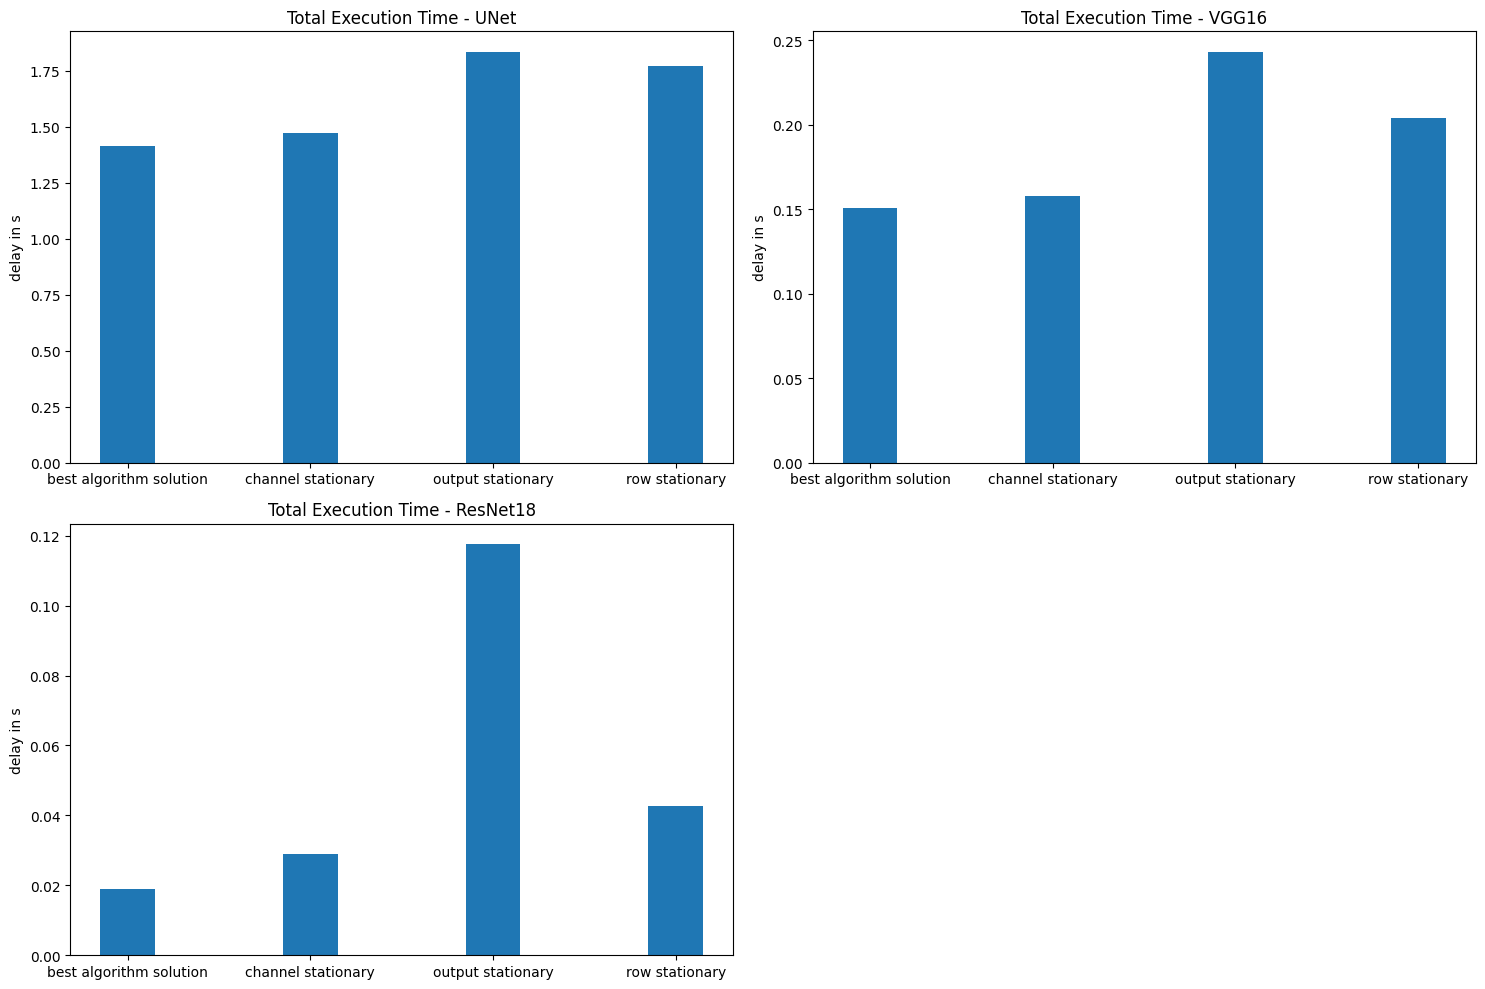

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = ["best algorithm solution", "channel stationary", "output stationary", "row stationary"]
y_values_UNet = [1.4159609200000003, 1.4735108000000003, 1.8338547200000002, 1.77178192]
y_values_VGG16 = [0.15080694, 0.15805439999999998, 0.2430432, 0.20385792000000003]
y_values_ResNet18 = [0.01900086, 0.028851199999999987, 0.11750399999999998, 0.042828799999999986]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("delay in s")
ax1.set_title("Total Execution Time - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("delay in s")
ax2.set_title("Total Execution Time - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("delay in s")
ax3.set_title("Total Execution Time - ResNet18")

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

In [24]:
fig.savefig("./experiment_dataflow_delay.png")

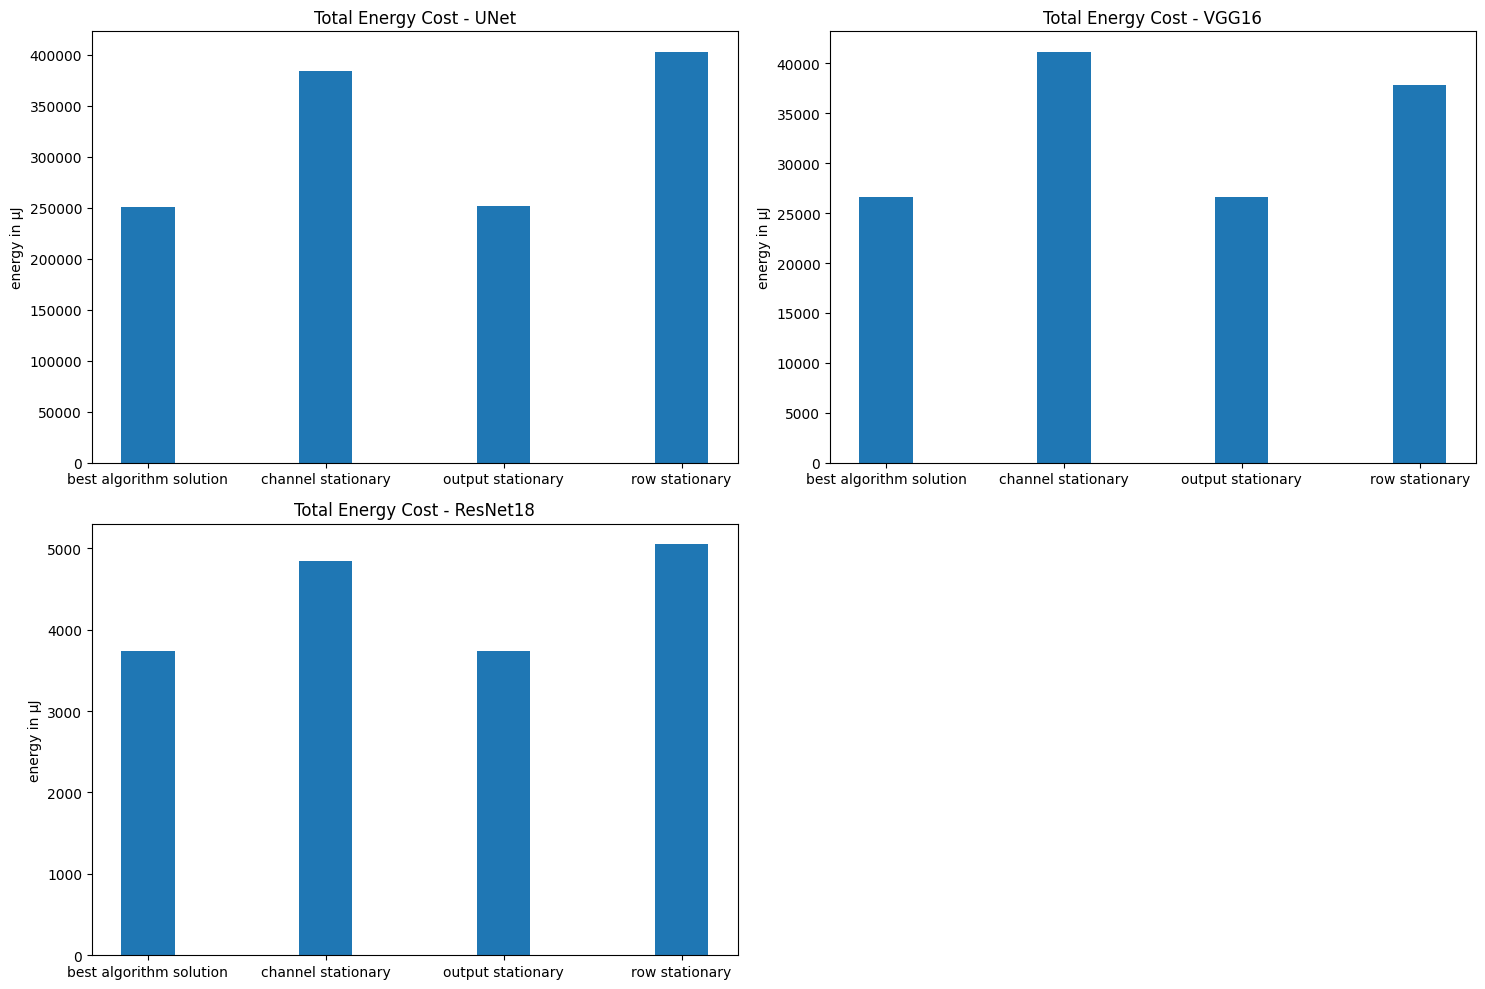

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = ["best algorithm solution", "channel stationary", "output stationary", "row stationary"]
y_values_UNet = [250470, 383755, 251200, 402671]
y_values_VGG16 = [26629, 41141, 26629, 37819]
y_values_ResNet18 = [3737, 4845, 3737, 5047]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("energy in μJ")
ax1.set_title("Total Energy Cost - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("energy in μJ")
ax2.set_title("Total Energy Cost - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("energy in μJ")
ax3.set_title("Total Energy Cost - ResNet18")

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

In [22]:
fig.savefig("./experiment_dataflow_energy.png")

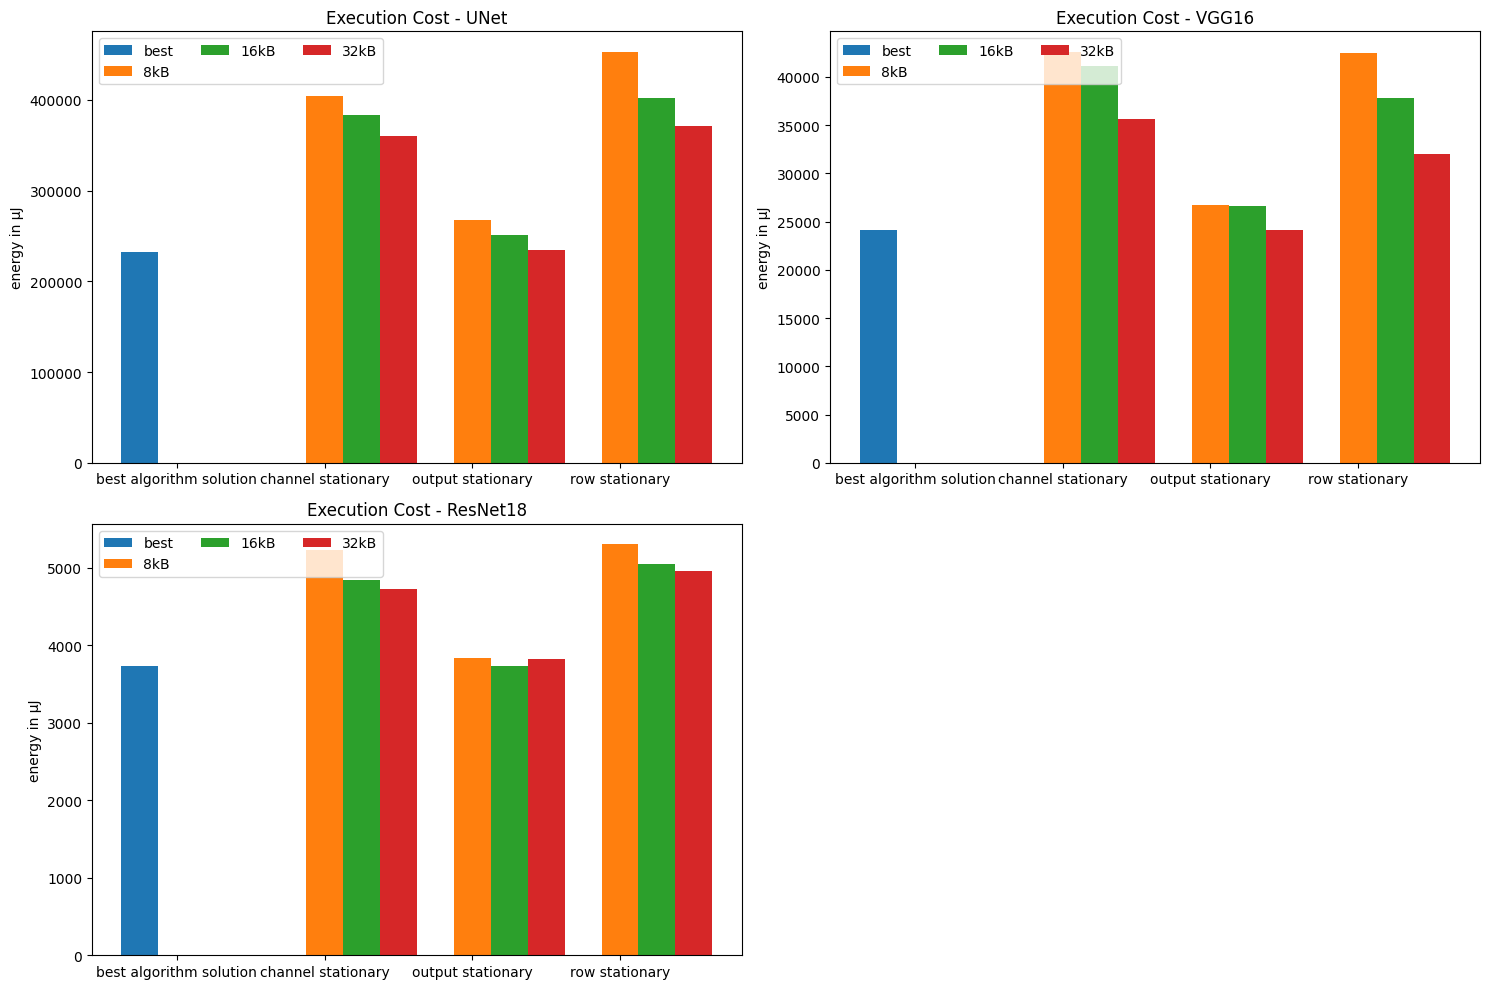

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_values = ("best algorithm solution", "channel stationary", "output stationary", "row stationary")

y_values_UNet = {
    'best':(232109, 0, 0, 0),
    '8kB': (0, 404697, 267826, 453046),
    '16kB': (0, 383755, 251200, 402671),
    '32kB': (0, 360808, 234914, 371472),
}

y_values_VGG16 = {
    'best':(24073, 0, 0, 0),
    '8kB': (0, 42584, 26744, 42439),
    '16kB': (0, 41141, 26629, 37819),
    '32kB': (0, 35606, 24073, 31959),
}

y_values_ResNet18 = {
    'best':(3737, 0, 0, 0),
    '8kB': (0, 5221, 3833, 5299),
    '16kB': (0, 4845, 3737, 5047),
    '32kB': (0, 4730, 3822, 4959),
}

x1 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_UNet.items():
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('energy in µJ')
ax1.set_title('Execution Cost - UNet')
ax1.set_xticks(x1 + width, x_values)
ax1.legend(loc='upper left', ncols=3)

x2 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_VGG16.items():
        offset = width * multiplier
        rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('energy in µJ')
ax2.set_title('Execution Cost - VGG16')
ax2.set_xticks(x2 + width, x_values)
ax2.legend(loc='upper left', ncols=3)

x3 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_ResNet18.items():
        offset = width * multiplier
        rects = ax3.bar(x3 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('energy in µJ')
ax3.set_title('Execution Cost - ResNet18')
ax3.set_xticks(x3 + width, x_values)
ax3.legend(loc='upper left', ncols=3)

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

In [9]:
fig.savefig("./experiment_energy_globalBuffer.png")

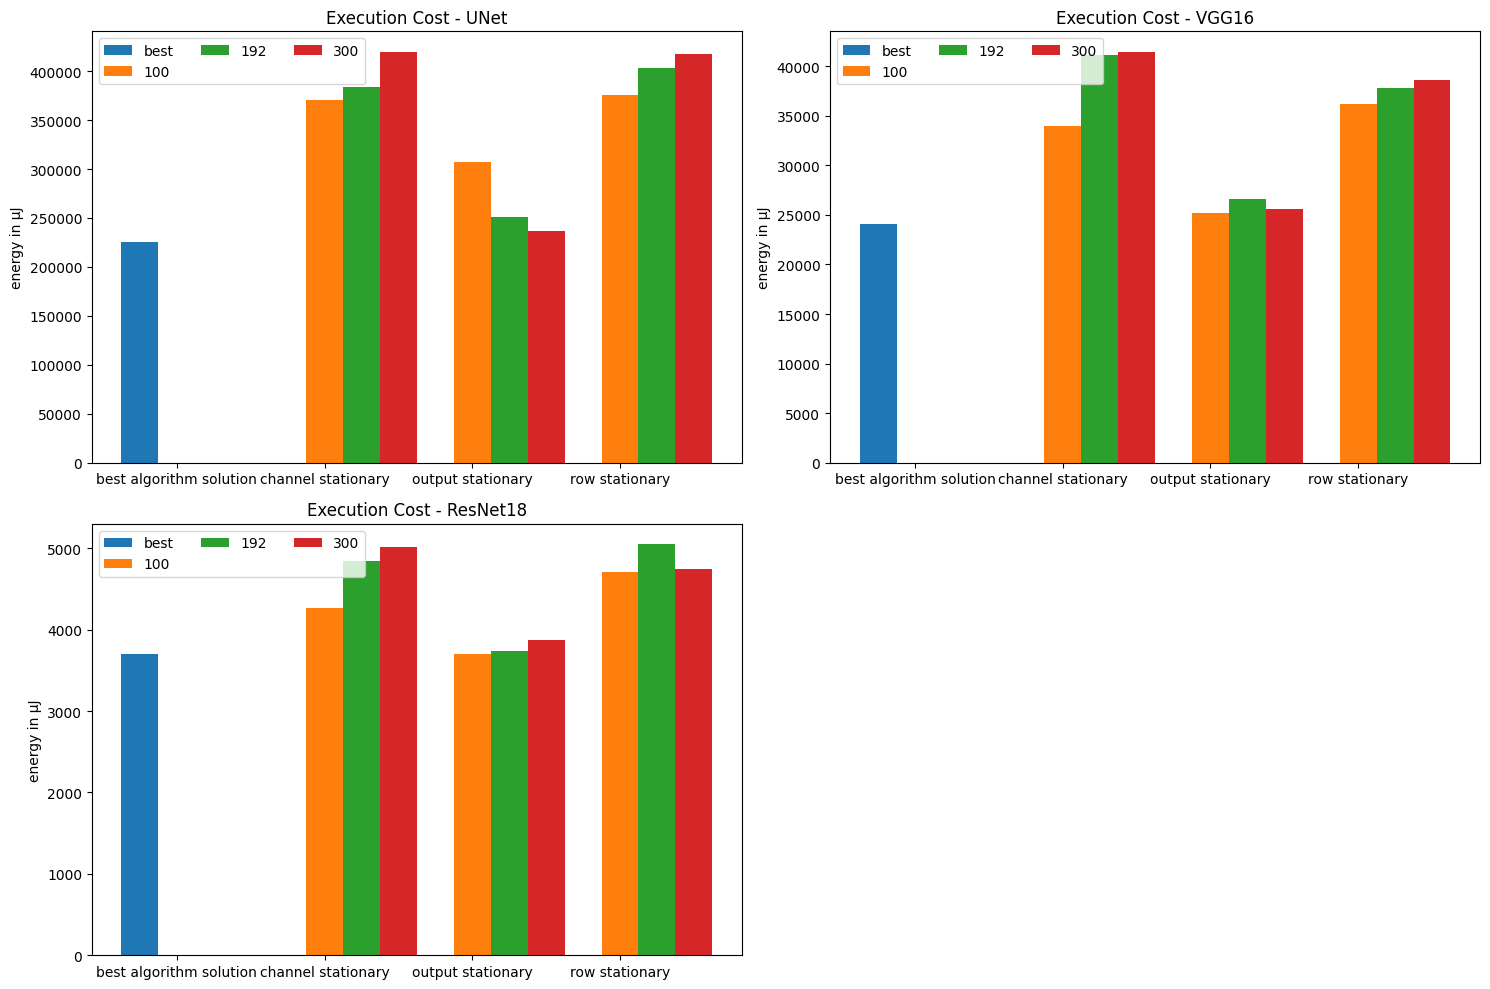

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_values = ("best algorithm solution", "channel stationary", "output stationary", "row stationary")

y_values_UNet = {
    'best':(225835, 0, 0, 0),
    '100': (0, 370334, 307642, 376045),
    '192': (0, 383755, 251200, 402671),
    '300': (0, 419610, 236624, 417046),
}

y_values_VGG16 = {
    'best':(24092, 0, 0, 0),
    '100': (0, 33916, 25191, 36152),
    '192': (0, 41141, 26629, 37819),
    '300': (0, 41439, 25549, 38577),
}

y_values_ResNet18 = {
    'best':(3701, 0, 0, 0),
    '100': (0, 4265, 3701, 4706),
    '192': (0, 4845, 3737, 5047),
    '300': (0, 5020, 3871, 4741),
}

x1 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_UNet.items():
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('energy in µJ')
ax1.set_title('Execution Cost - UNet')
ax1.set_xticks(x1 + width, x_values)
ax1.legend(loc='upper left', ncols=3)

x2 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_VGG16.items():
        offset = width * multiplier
        rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('energy in µJ')
ax2.set_title('Execution Cost - VGG16')
ax2.set_xticks(x2 + width, x_values)
ax2.legend(loc='upper left', ncols=3)

x3 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_ResNet18.items():
        offset = width * multiplier
        rects = ax3.bar(x3 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('energy in µJ')
ax3.set_title('Execution Cost - ResNet18')
ax3.set_xticks(x3 + width, x_values)
ax3.legend(loc='upper left', ncols=3)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()

In [11]:
fig.savefig("./experiment_energy_scratchpad.png")

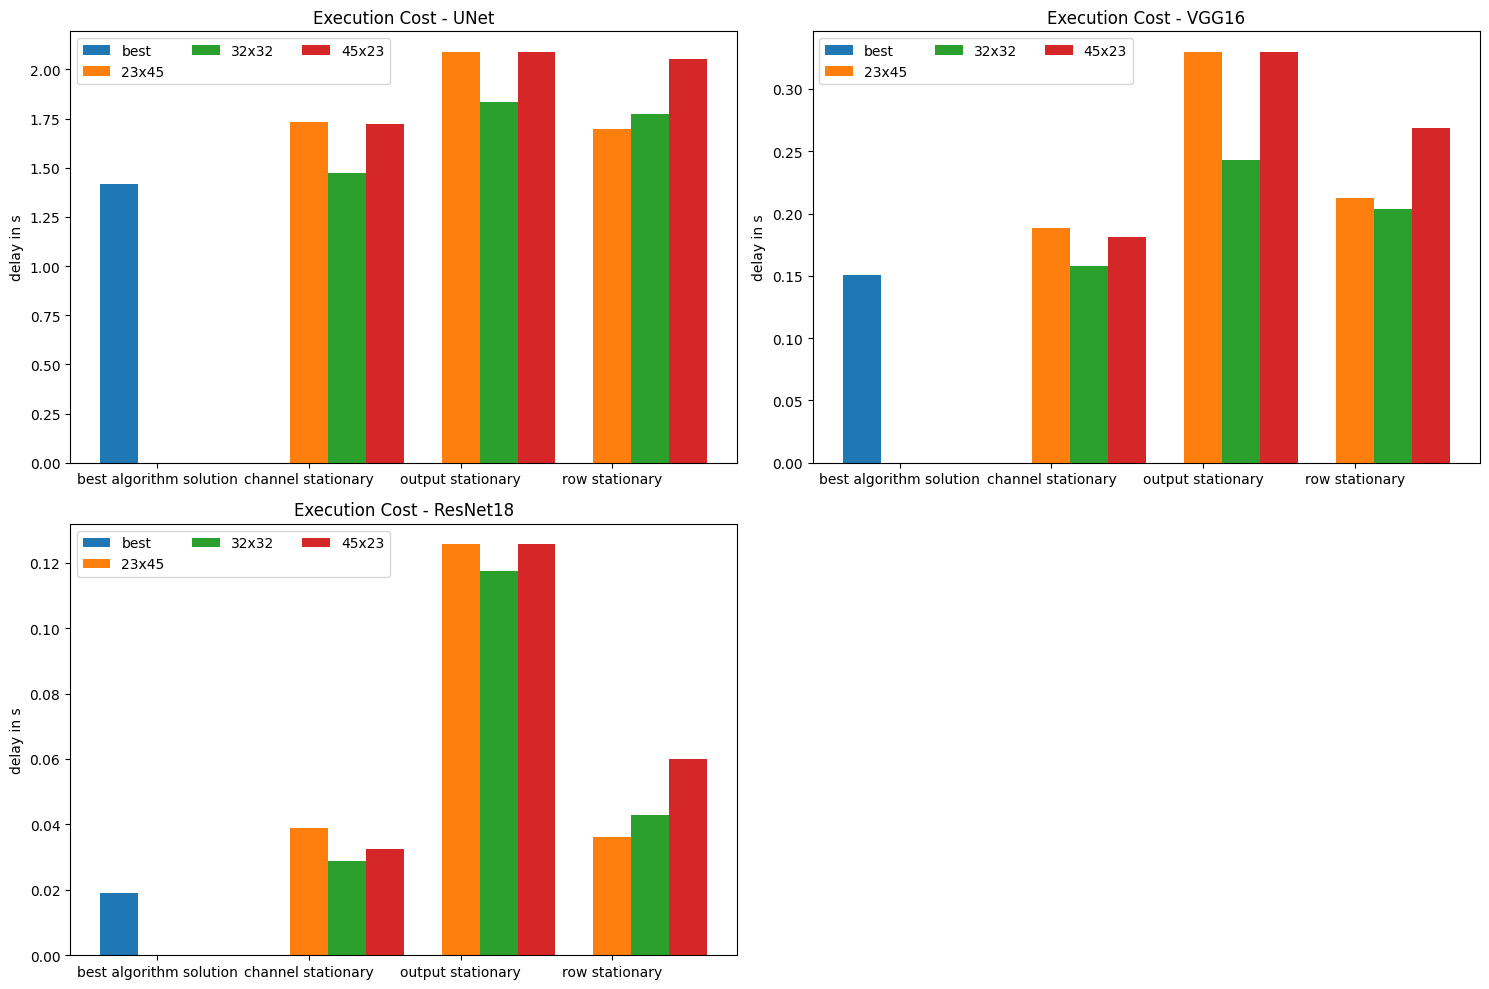

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_values = ("best algorithm solution", "channel stationary", "output stationary", "row stationary")

y_values_UNet = {
    'best':(1.4159550000000003, 0, 0, 0),
    '23x45': (0, 1.73140076, 2.0893075199999998, 1.69513232),
    '32x32': (0, 1.4735108000000003, 1.8338547200000002, 1.77178192),
    '45x23': (0, 1.7219906400000002, 2.0893075199999998, 2.0539028299999997),
}

y_values_VGG16 = {
    'best':(0.15080694, 0, 0, 0),
    '23x45': (0, 0.18860688, 0.32969087999999996, 0.21224447999999999),
    '32x32': (0, 0.15805439999999998, 0.2430432, 0.20385792000000003),
    '45x23': (0, 0.18112752000000001, 0.32969087999999996, 0.26836992),
}

y_values_ResNet18 = {
    'best':(0.018906779999999998, 0, 0, 0),
    '23x45': (0, 0.038808, 0.12560192, 0.036305920000000005),
    '32x32': (0, 0.028851199999999987, 0.11750399999999998, 0.042828799999999986),
    '45x23': (0, 0.03245564, 0.12560192, 0.05988864000000001),
}

x1 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_UNet.items():
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('delay in s')
ax1.set_title('Execution Cost - UNet')
ax1.set_xticks(x1 + width, x_values)
ax1.legend(loc='upper left', ncols=3)

x2 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_VGG16.items():
        offset = width * multiplier
        rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('delay in s')
ax2.set_title('Execution Cost - VGG16')
ax2.set_xticks(x2 + width, x_values)
ax2.legend(loc='upper left', ncols=3)

x3 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_ResNet18.items():
        offset = width * multiplier
        rects = ax3.bar(x3 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('delay in s')
ax3.set_title('Execution Cost - ResNet18')
ax3.set_xticks(x3 + width, x_values)
ax3.legend(loc='upper left', ncols=3)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()

In [13]:
fig.savefig("./experiment_delay_shape.png")

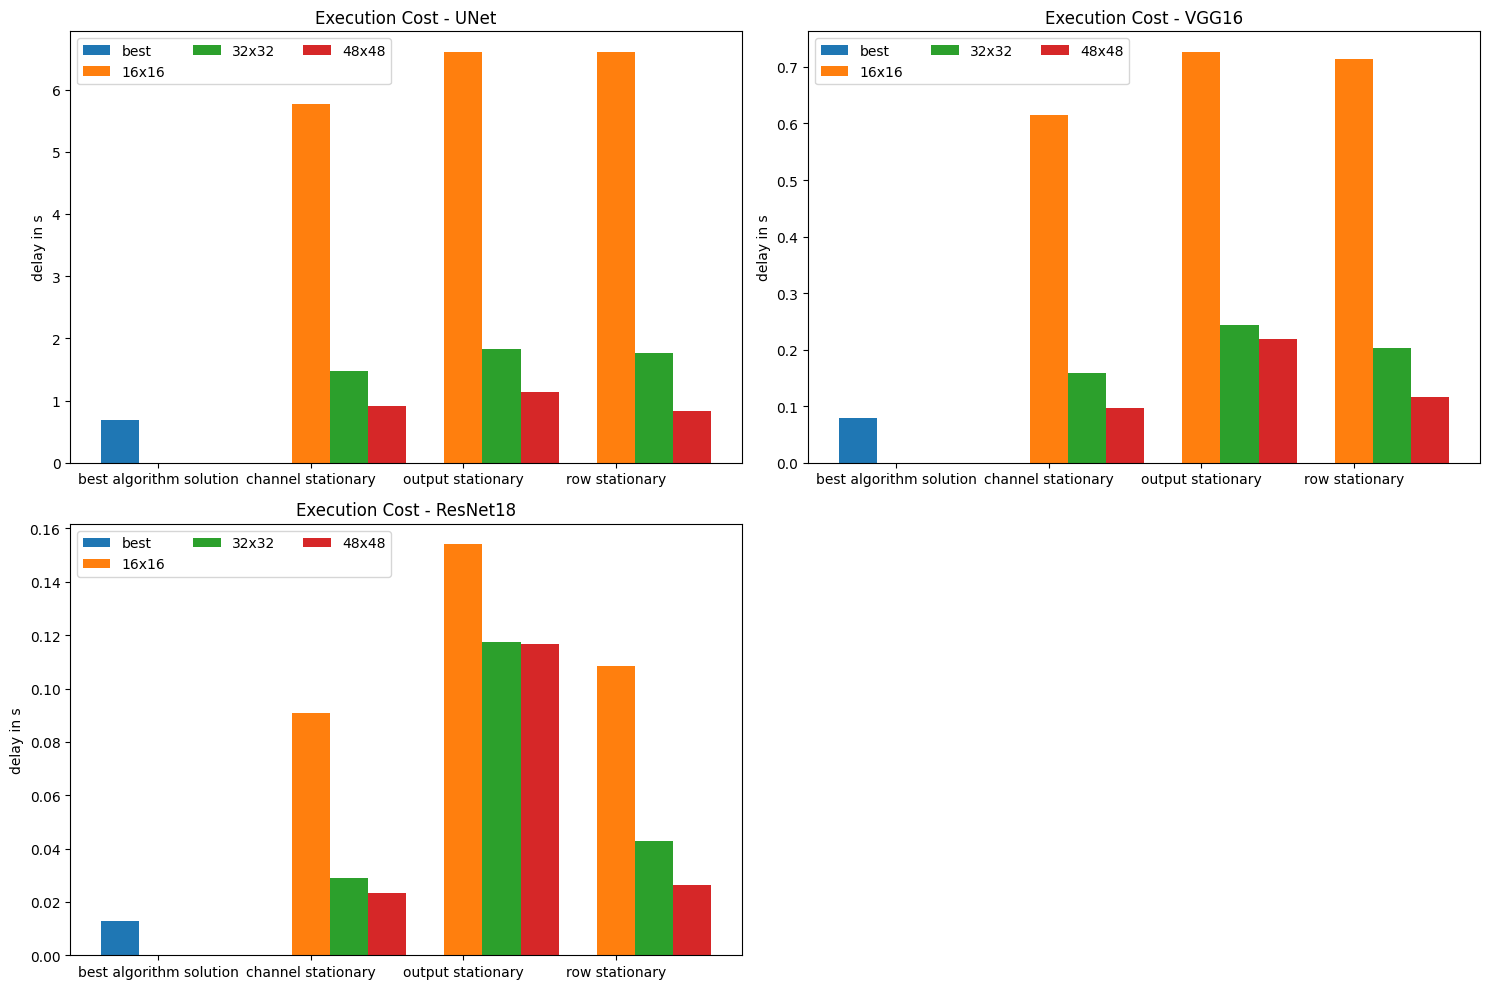

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_values = ("best algorithm solution", "channel stationary", "output stationary", "row stationary")

y_values_UNet = {
    'best':(0.6923517, 0, 0, 0),
    '16x16': (0, 5.771057440000002, 6.5962304000000005, 6.60583712),
    '32x32': (0, 1.4735108000000003, 1.8338547200000002, 1.77178192),
    '48x48': (0, 0.9172100000000001, 1.1389248, 0.83970192),
}

y_values_VGG16 = {
    'best':(0.07976760000000001, 0, 0, 0),
    '16x16': (0, 0.61415424, 0.72665856, 0.7137177600000001),
    '32x32': (0, 0.15805439999999998, 0.2430432, 0.20385792000000003),
    '48x48': (0, 0.09756684000000002, 0.21829823999999998, 0.11569152000000003),
}

y_values_ResNet18 = {
    'best':(0.012857730000000001, 0, 0, 0),
    '16x16': (0, 0.09081855999999996, 0.15403199999999997, 0.10848767999999999),
    '32x32': (0, 0.028851199999999987, 0.11750399999999998, 0.042828799999999986),
    '48x48': (0, 0.02336663, 0.11684544, 0.026414080000000006),
}

x1 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_UNet.items():
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('delay in s')
ax1.set_title('Execution Cost - UNet')
ax1.set_xticks(x1 + width, x_values)
ax1.legend(loc='upper left', ncols=3)

x2 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_VGG16.items():
        offset = width * multiplier
        rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('delay in s')
ax2.set_title('Execution Cost - VGG16')
ax2.set_xticks(x2 + width, x_values)
ax2.legend(loc='upper left', ncols=3)

x3 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_ResNet18.items():
        offset = width * multiplier
        rects = ax3.bar(x3 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('delay in s')
ax3.set_title('Execution Cost - ResNet18')
ax3.set_xticks(x3 + width, x_values)
ax3.legend(loc='upper left', ncols=3)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()

In [15]:
fig.savefig("./experiment_delay_size.png")

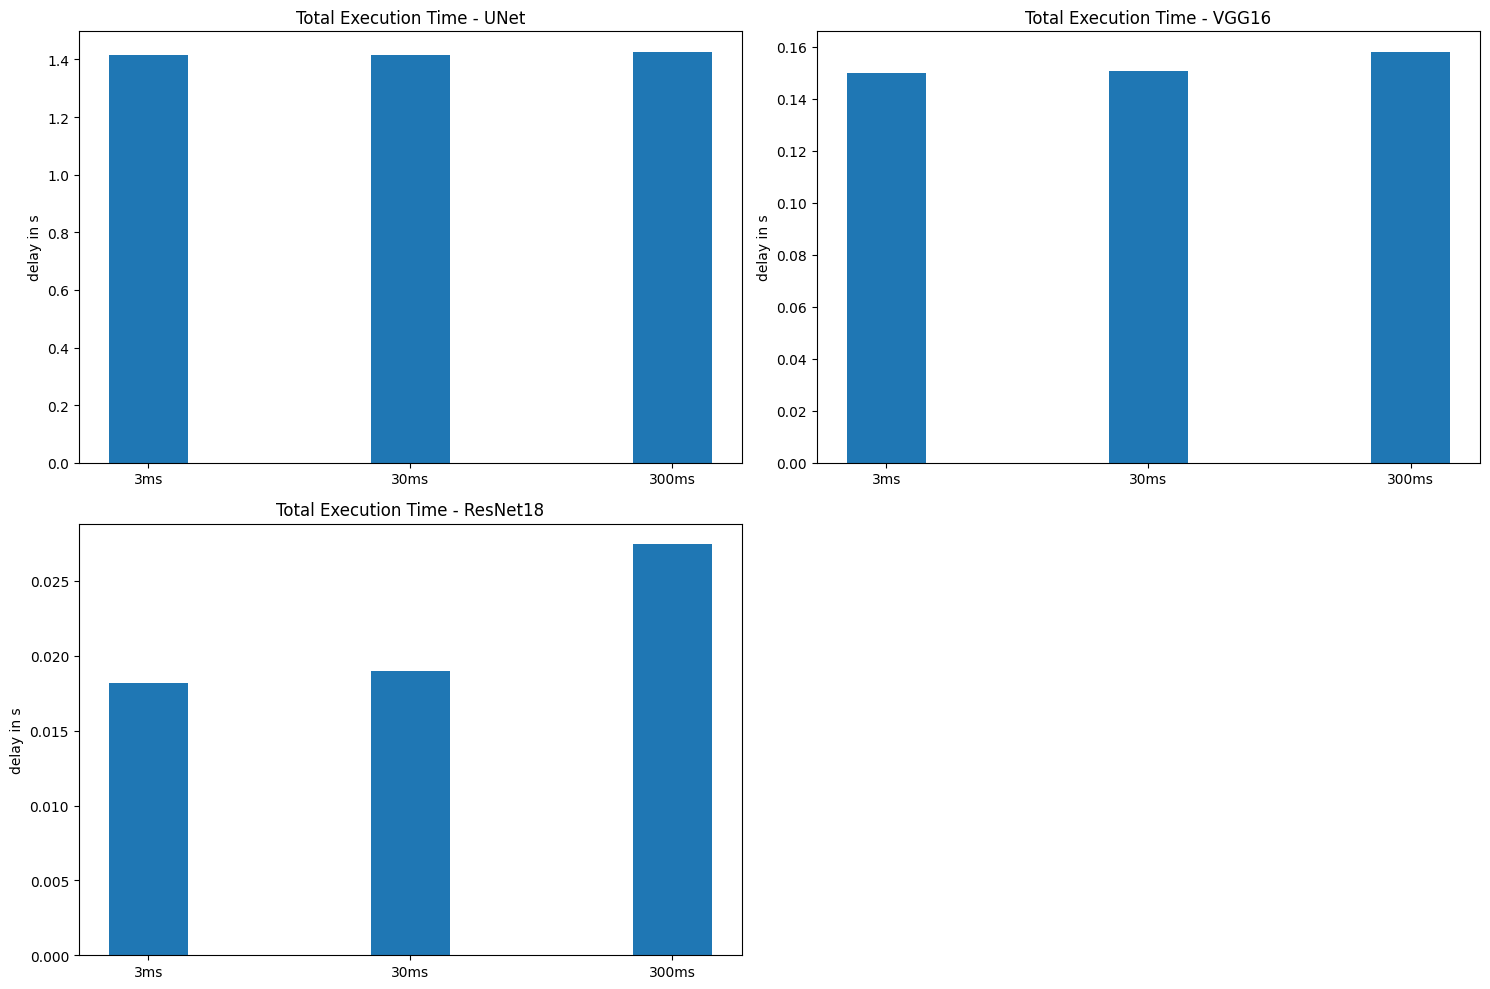

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = [ "3ms", "30ms", "300ms"]
y_values_UNet = [1.4142734200000004, 1.4159609200000003, 1.4262700400000003]
y_values_VGG16 = [0.14996318999999997, 0.15080694, 0.15805439999999998]
y_values_ResNet18 = [0.018157109999999997, 0.01900086, 0.027438359999999988]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("delay in s")
ax1.set_title("Total Execution Time - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("delay in s")
ax2.set_title("Total Execution Time - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("delay in s")
ax3.set_title("Total Execution Time - ResNet18")

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

In [17]:
fig.savefig("./experiment_reconfig_time.png")

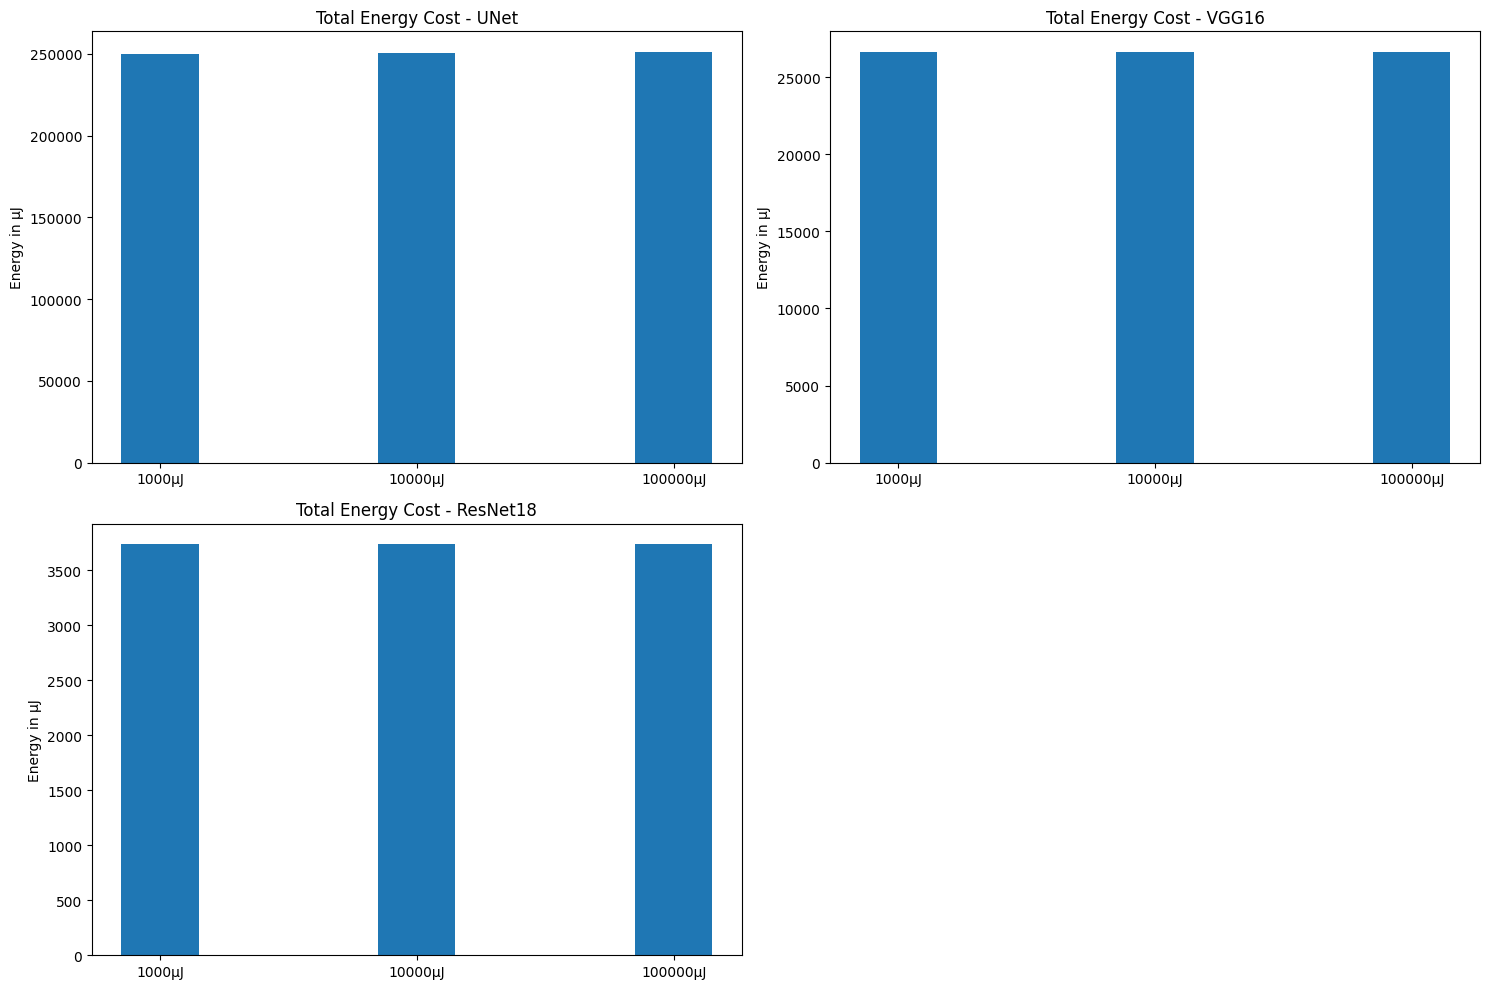

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = ["1000µJ", "10000µJ", "100000µJ"]
y_values_UNet = [249863, 250470, 251200]
y_values_VGG16 = [26629, 26629, 26629]
y_values_ResNet18 = [3737, 3737, 3737]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("Energy in μJ")
ax1.set_title("Total Energy Cost - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("Energy in μJ")
ax2.set_title("Total Energy Cost - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("Energy in μJ")
ax3.set_title("Total Energy Cost - ResNet18")

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

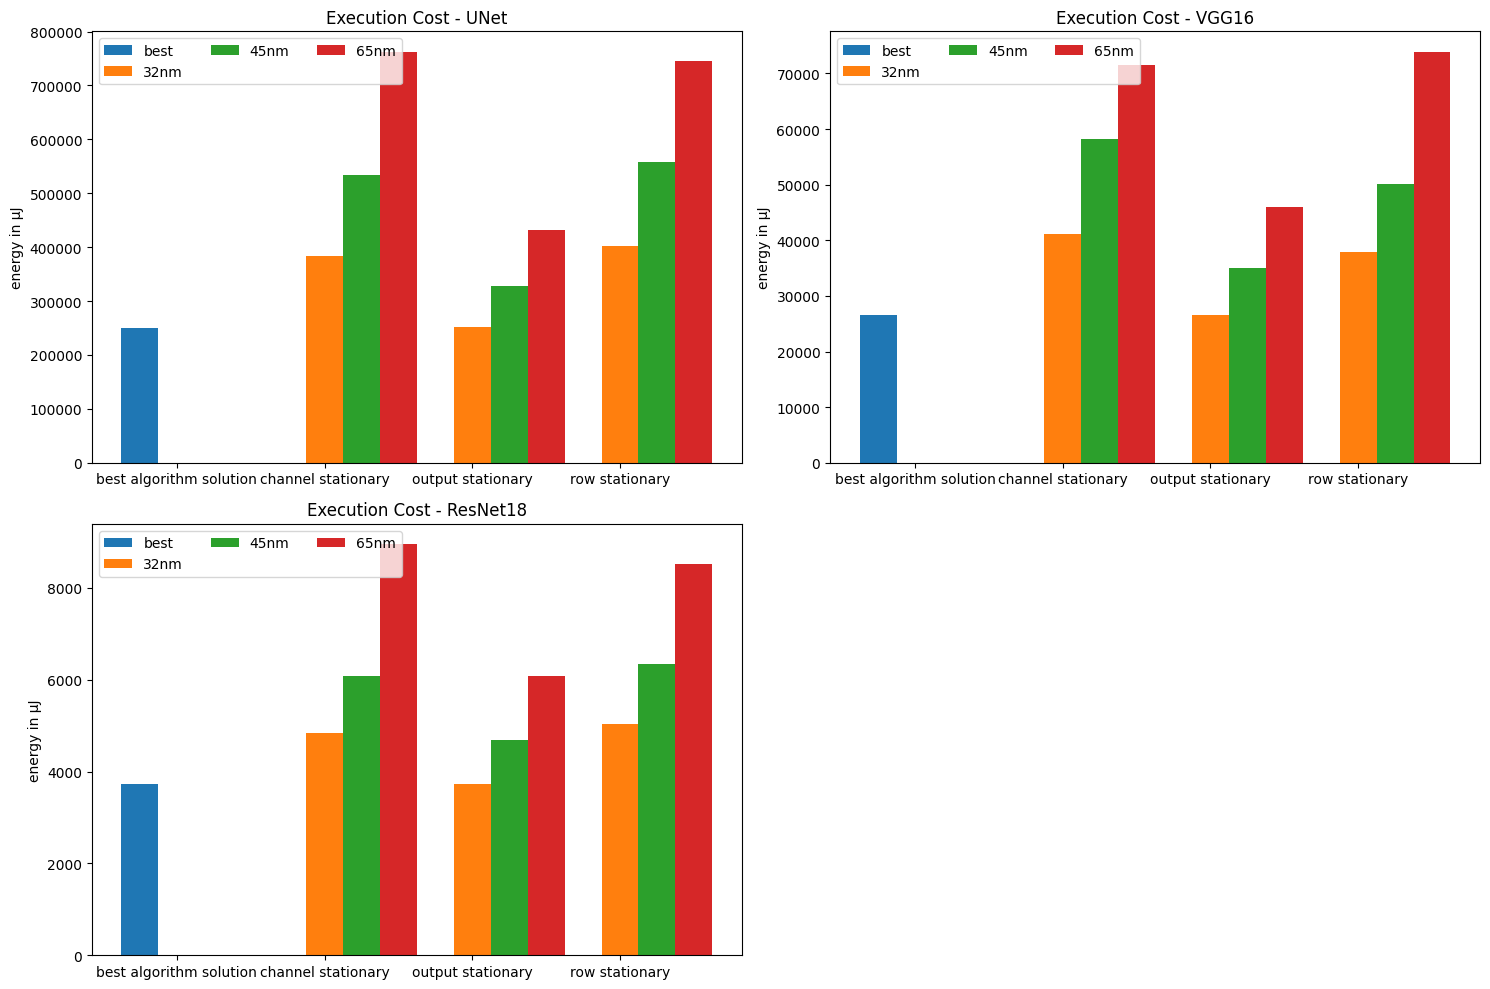

In [19]:
import matplotlib.pyplot as plt
import numpy as np

#fig, ((ax1, ax2), ax3) = plt.subplots(2,2)

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_values = ("best algorithm solution", "channel stationary", "output stationary", "row stationary")

y_values_UNet = {
    'best':(250470, 0, 0, 0),
    '32nm': (0, 383755, 251200, 402671),
    '45nm': (0, 534443, 328157, 558330),
    '65nm': (0, 762297, 431947, 745347),
}

y_values_VGG16 = {
    'best':(26629, 0, 0, 0),
    '32nm': (0, 41141, 26629, 37819),
    '45nm': (0, 58141, 34946, 50145),
    '65nm': (0, 71480, 45968, 73870),
}

y_values_ResNet18 = {
    'best':(3737, 0, 0, 0),
    '32nm': (0, 4845, 3737, 5047),
    '45nm': (0, 6082, 4692, 6339),
    '65nm': (0, 8949, 6089, 8527),
}

x1 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_UNet.items():
        offset = width * multiplier
        rects = ax1.bar(x1 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('energy in µJ')
ax1.set_title('Execution Cost - UNet')
ax1.set_xticks(x1 + width, x_values)
ax1.legend(loc='upper left', ncols=3)

x2 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_VGG16.items():
        offset = width * multiplier
        rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('energy in µJ')
ax2.set_title('Execution Cost - VGG16')
ax2.set_xticks(x2 + width, x_values)
ax2.legend(loc='upper left', ncols=3)

x3 = np.arange(len(x_values))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in y_values_ResNet18.items():
        offset = width * multiplier
        rects = ax3.bar(x3 + offset, measurement, width, label=attribute)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('energy in µJ')
ax3.set_title('Execution Cost - ResNet18')
ax3.set_xticks(x3 + width, x_values)
ax3.legend(loc='upper left', ncols=3)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()

In [20]:
fig.savefig("./experiment_technology_node.png")

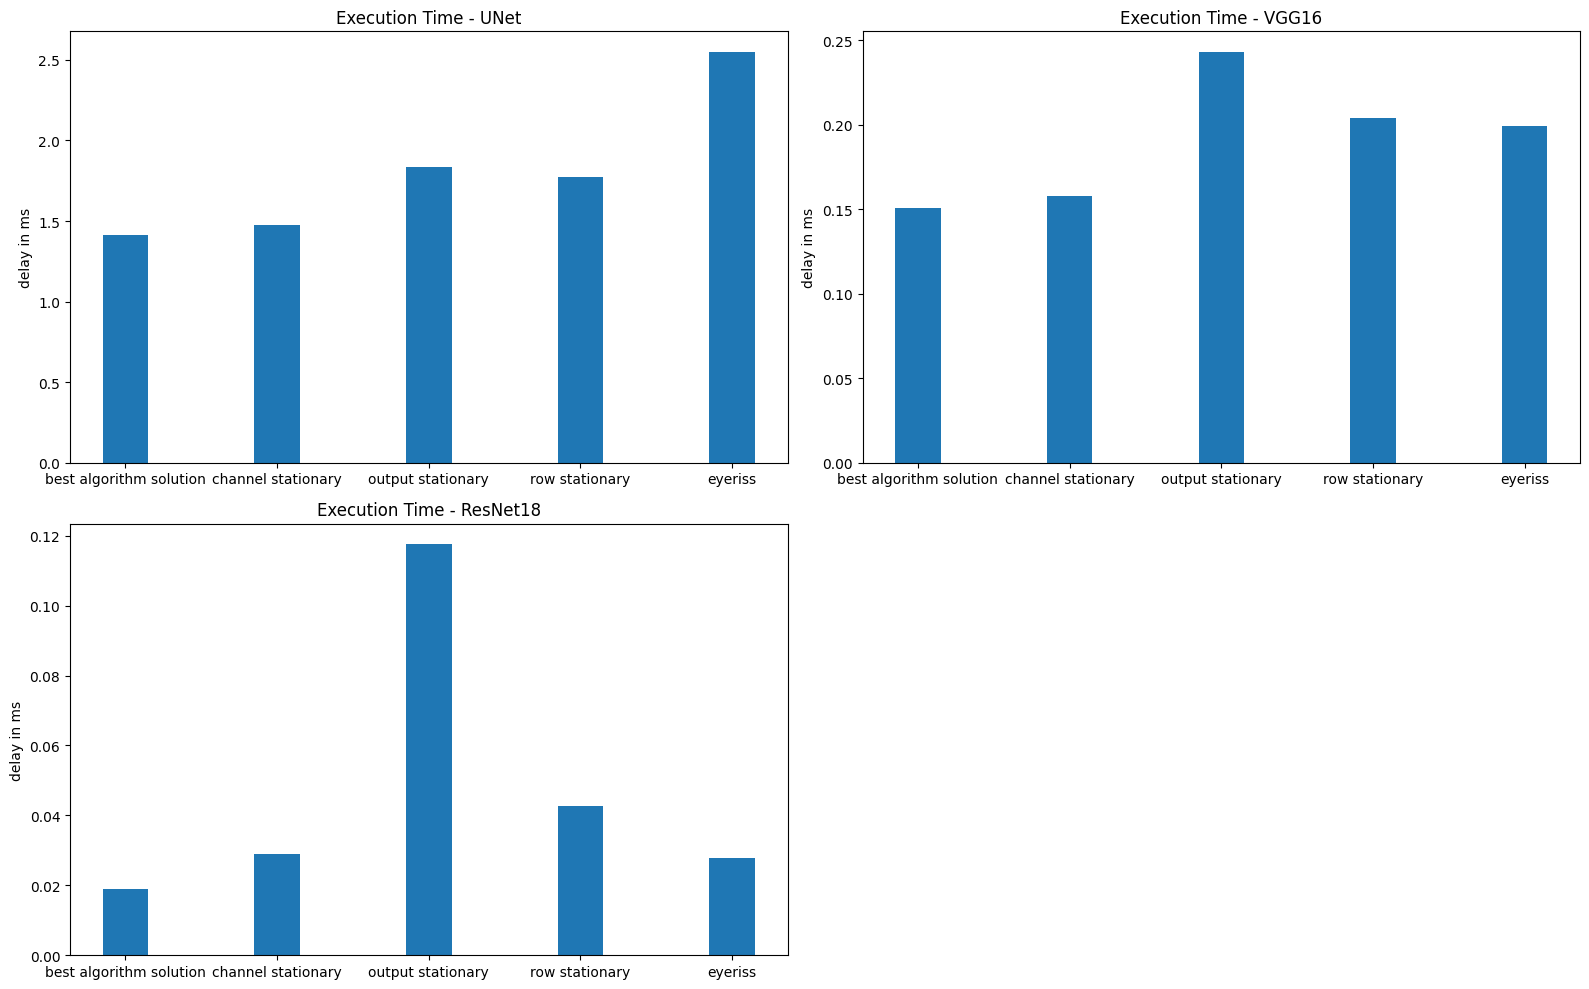

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = ["best algorithm solution", "channel stationary", "output stationary", "row stationary", "eyeriss"]
y_values_UNet = [1.4159609200000003, 1.4735108000000003, 1.8338547200000002, 1.77178192, 2.5495967100000003]
y_values_VGG16 = [0.15080694, 0.15805439999999998, 0.2430432, 0.20385792000000003, 0.19891199999999998]
y_values_ResNet18 = [0.01900086, 0.028851199999999987, 0.11750399999999998, 0.042828799999999986, 0.027890240000000004]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("delay in ms")
ax1.set_title("Execution Time - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("delay in ms")
ax2.set_title("Execution Time - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("delay in ms")
ax3.set_title("Execution Time - ResNet18")

fig.set_figwidth(16)
fig.set_figheight(10)
fig.tight_layout()

In [27]:
fig.savefig("./experiment_eyeriss_delay.png")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((2,2),(0, 0))
ax2 = plt.subplot2grid((2,2),(0, 1))
ax3 = plt.subplot2grid((2,2),(1, 0))

x_labels = ["best algorithm solution", "channel stationary", "output stationary", "row stationary", "eyeriss"]
y_values_UNet = [, , , , ]
y_values_VGG16 = [, , , , ]
y_values_ResNet18 = [, , , , ]

ax1.bar(x_labels, y_values_UNet, width = 0.3)
ax1.set_ylabel("energy in μJ")
ax1.set_title("Total Energy Cost - UNet")

ax2.bar(x_labels, y_values_VGG16, width = 0.3)
ax2.set_ylabel("energy in μJ")
ax2.set_title("Total Energy Cost - VGG16")

ax3.bar(x_labels, y_values_ResNet18, width = 0.3)
ax3.set_ylabel("energy in μJ")
ax3.set_title("Total Energy Cost - ResNet18")

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()